In [1]:
push!(LOAD_PATH, "./BOCPD/src")
using BOCPD
using Plots
gr()

┌ Info: Recompiling stale cache file /home/fxb/.julia/compiled/v1.0/BOCPD.ji for BOCPD [top-level]
└ @ Base loading.jl:1190


Plots.GRBackend()

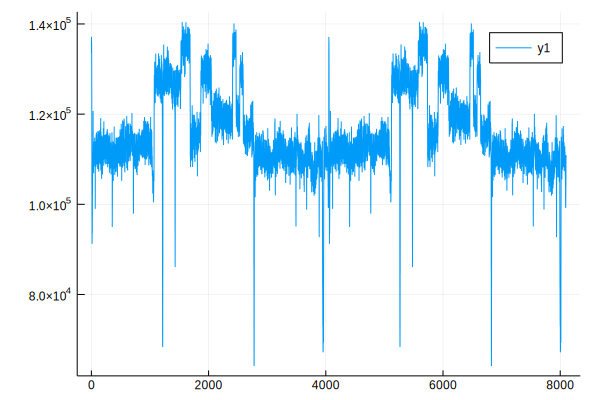

In [2]:
x = open( "./data/well.txt", "r" ) do fp
  readlines( fp )
end
x = map(x) do x parse(Float64,x) end
x=vcat(x,x)
plot(x)


In [3]:
function prune_condition(probs::Array{Float64,1}, threshold::Number, typ::Symbol)::Array{Bool,1}
    if(typ == :Keep_K)
        temp = sort(probs)
        thres = temp[end-(threshold-1)]
        map(probs) do x >(x,thres) end
    elseif(typ == :Threshold)
        map(probs) do x >(x,threshold) end
    end
end



prune_condition (generic function with 1 method)

In [4]:
n = length(x)
y = collect(range(1.0,stop=n,length=n))

dist =  BOCPD.StudentT(0.1, 1.0, 1.0, 0.0)
probs = [1.0]
H = 1.0 / 100.0   
changepoints = Int64[]
rslt_t=Int64[]
rslt_lag=Int64[]
rslt_cp=Int64[]
max_lag=10
test_sz = 3 
max_size=1000
typ=:Keep_K
threshold=200
t_0 = 1
is_pruning=true
for t_n in  1:n
    probs=BOCPD.calculate(x[t_n],dist,probs, H)
    lag = argmax(probs)
    push!(rslt_t,t_n)
    push!(rslt_lag,lag)
    push!(rslt_cp,0)
    
    sz = length(probs)
    if(sz > max_lag*2 && lag <= max_lag && BOCPD.detect(rslt_lag,test_sz))
        rslt_cp[t_n - lag] = 200000
        push!(changepoints,t_n - lag)        
        probs = probs[1:lag]
        BOCPD.prune!(dist, lag)
    else
       if(is_pruning && sz > max_size)                
            cond = prune_condition(probs,threshold,typ)
            probs = probs[cond]                
            BOCPD.prune!(dist,cond)
            println("pruning at ", t_n)
       end            
    end
end
print("changepoints:",changepoints)

pruning at 1000
pruning at 2427
pruning at 3771
pruning at 4943
pruning at 6477
pruning at 7821
changepoints:[1071, 1211, 1426, 2770, 3942, 5121, 5261, 5476, 6820, 7992]

In [5]:
Plots.scatter(y,x,markersize=1, c=:blue,xaxis=("t", (-2, 8000), 0:500:8000))
plot!(y,rslt_cp)